<a href="https://colab.research.google.com/github/Arseniy-Polyakov/applied_linguistics_course/blob/main/Task_2_Topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В данной работе будем проводить тематическое моделирование корпуса советской песни с помощью BERTopic

Устанавливаем модель и необходимые библиотеки для работы

In [ ]:
!pip install bertopic gensim

In [1]:
!pip install pymorphy3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 48.7 MB/s eta 0:00:00


Импортируем необходимые модули для предобработки текста и работы с BERTopic

In [2]:
import re
import nltk
import pymorphy3
import pandas as pd
from nltk.corpus import stopwords
import umap.umap_ as UMAP
import hdbscan.hdbscan_ as HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import common_texts

Загружаем списки стоп-слов на русском языке для предобработки текстов

In [3]:
nltk.download("stopwords")
stop_words = stopwords.words("russian")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Загружаем данные из корпуса советской песни

In [4]:
df = pd.read_excel("corpus.xlsx")
df.head()

,id,year,country,lyrics_text,LOC,ORG,PER,Tag,artist,track,composer,lyricist
0,0,1964,USSR,Поднимать тугие паруса —\nЭто значит верить в ...,NaN,NaN,Леонов\n,"творчество, любовь, судьба",Эдита Пьеха,Это здорово,А. Броневицкий,И. Шаферан
1,1,1965,USSR,"Бура-Бура-Буратино,\nМилый мальчик мой,\nТы ли...",NaN,NaN,Бура-Бура-Буратино\nБура-Буратино\n,любовь,Раиса Неменова,Помоги Мне Буратино,"В. Хвойницкий, У. Лапсинь",Г. Бейлин
2,2,1967,USSR,"Прыг-скок, утром на лужок. \nПрыг-скок, выскоч...",NaN,NaN,Летка-Енка\n,природа,Тамара Миансарова,Летка Енка,Р. Лехтинен,М. Пляцковский
3,3,1966,USSR,"Вот и опять не спит мой Ленинград,\nКак он кра...",Летний сад\nНева\nЛенинград\n,NaN,NaN,город,Эдита Пьеха,Белая Ночь,М. Фрадкин,Е.Долматовский
4,4,1966,USSR,"В январе зима всерьез,\nОтморозить можно нос.\...",Ленинград\nНева\n,NaN,NaN,город,Анатолий Королёв,Моржи,А. Броневицкий,С. Фогельсон


Напишем функцию препроцессинга текста (до этого были проведены эксперименты по обучению BERTopic без процессинга, в результате чего большое количество стоп-слов, а также форм одного слова попадали в триграммы)

In [ ]:
def preprocessing(text: str) -> str:
  """
  Функция для препроцессинга текста: удаление знаков препинания и стоп-слов,
  приведение к нижнему регистру, лемматизация
  """
  lemmatizer = pymorphy3.MorphAnalyzer()
  text_without_punct = re.sub(r"[^а-яё\s\-]", "", text.lower())
  text_preprocessed = " ".join([lemmatizer.parse(token)[0].normal_form for token in text_without_punct.split() if token not in stop_words])
  return text_preprocessed

Выводим предобработанные тексты советских песен

In [ ]:
corpus_texts = list(df["lyrics_text"])
corpus_texts_preprocessed = [preprocessing(text) for text in corpus_texts]
corpus_texts_preprocessed

Загружаем модель эмбеддингов для векторизации текста

In [ ]:
embedding_model = SentenceTransformer("cointegrated/rubert-tiny2")

Загружаем векторизатор. Мы будем использовать векторизацию с помощью bow, а не TF-IDF или Word2Vec, так TF-IDF ставит большее значение для частотных слов в контексте одного документа, а модели типа Word2Vec учитывают контекст и порядок слов. В свою очередь для моделей типа трансформеры необходимо разносильное представление каждого токена

In [ ]:
vectorizer_model = CountVectorizer(ngram_range=(1, 3), min_df=5)

Используем модель UMAP для снижения размерности

In [ ]:
umap_model = UMAP.UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

Используем модель HDBSCAN для ограничения минимального количества кластеров (топиков)

In [ ]:
hdbscan_model = HDBSCAN.HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

Создаем объект модели, подаем в аргументы модели векторизации, эмбеддингов, уменьшения размерности и ограничения по количеству топиков, задаем язык

In [ ]:
bertopic_model = BERTopic(
  language = "Russian",
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  min_topic_size=10,
  calculate_probabilities=False,

  verbose=True
)

Обучаем модель на нашем корпусе

In [ ]:
topics, probs = bertopic_model.fit_transform(corpus_texts_preprocessed)

Выведем основную информацию о полученных кластерах

In [ ]:
bertopic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,671,-1_мы_земля_твой_ты,"[мы, земля, твой, ты, песня, наш, город, день,...",[тот злой тишина тот неверный тень развести мо...
1,0,140,0_ночь_снег_извинить_свет,"[ночь, снег, извинить, свет, спешить, ты, прих...",[лунный свет равнина рассеянный вдалеке село о...
2,1,105,1_то_нота_всё_мол,"[то, нота, всё, мол, свой, бить, это, сказать,...",[лукоморье дуб простыть след дуб годиться парк...
3,2,65,2_любовь_трудный_сказать_могила,"[любовь, трудный, сказать, могила, дорога, сер...",[туча город встать воздух пахнуть гроза далёки...
4,3,52,3_наш_мы_поклониться_битва,"[наш, мы, поклониться, битва, солдат, бой, бат...",[птица петь дерево расти плечо плечо врастать ...
5,4,44,4_ах_однажды_иван_пара,"[ах, однажды, иван, пара, выходить, одесса, де...",[развесёлый цыган молдавия гулять один село бо...
6,5,43,5_любовь_жизнь_звать_мир,"[любовь, жизнь, звать, мир, мой, любить, сказа...",[родный имя натали звучать загадочно грустно о...
7,6,42,6_весна_песня_играть_гармошка,"[весна, песня, играть, гармошка, где то, приве...",[мой серёга шагать петровка сам бровка сам бро...
8,7,26,7_ай_эх_жениться_ох,"[ай, эх, жениться, ох, вдоль, ой, волос, кудри...",[вдоль речка вдоль казанка сизый селезень плыт...
9,8,24,8_любовь_твой_голос_сердце,"[любовь, твой, голос, сердце, петь, вселенная,...",[мы ты мы ты казаться любовь любовь река течь ...


In [ ]:
bertopic_model.get_topic(21)

[('ошибка', 0.09865547384960158),
 ('нелепый', 0.09865547384960158),
 ('городок', 0.08016542581931674),
 ('самый', 0.06922849431175589),
 ('любить', 0.06517117374558512),
 ('уходить', 0.06437072475237009),
 ('милый', 0.06158446955547536),
 ('ой', 0.05468081442835861),
 ('ах', 0.04289348876631782),
 ('улыбка', 0.04185866434225869)]

Визуализируем наш результат

In [ ]:
bertopic_model.visualize_topics()

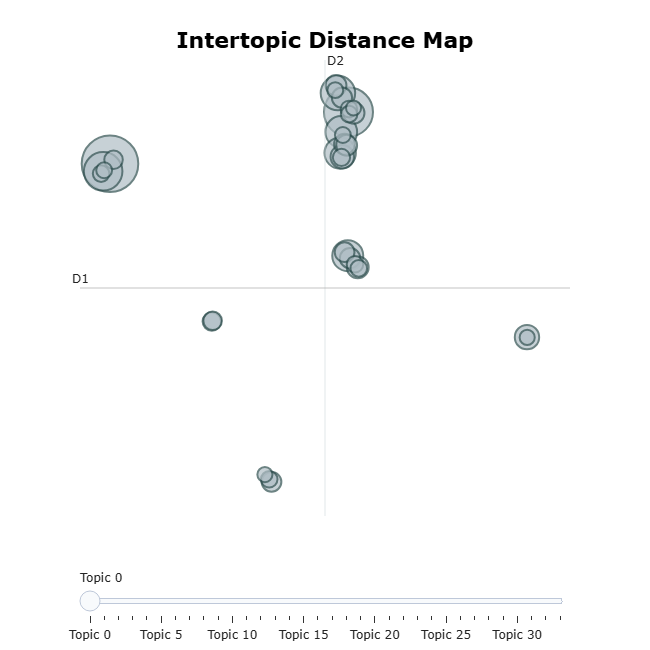

In [ ]:
bertopic_model.visualize_barchart()

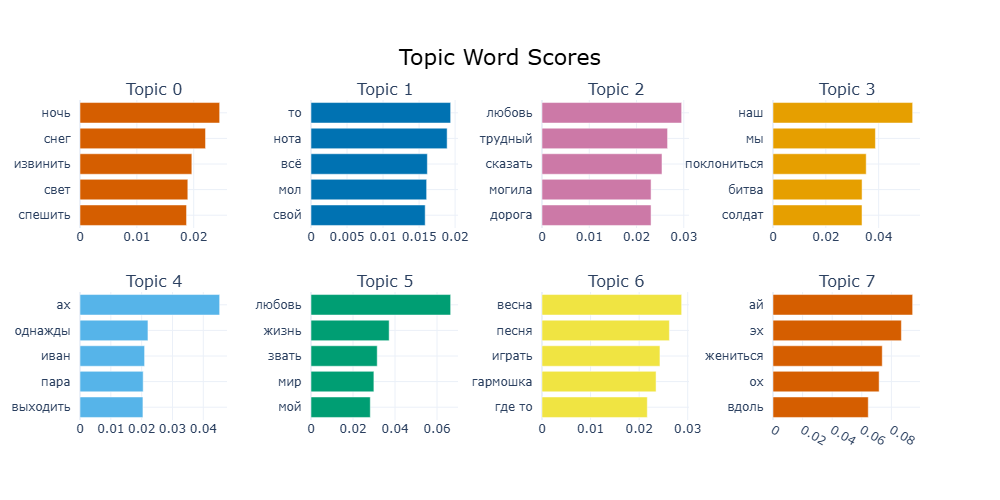

In [ ]:
bertopic_model.visualize_hierarchy()

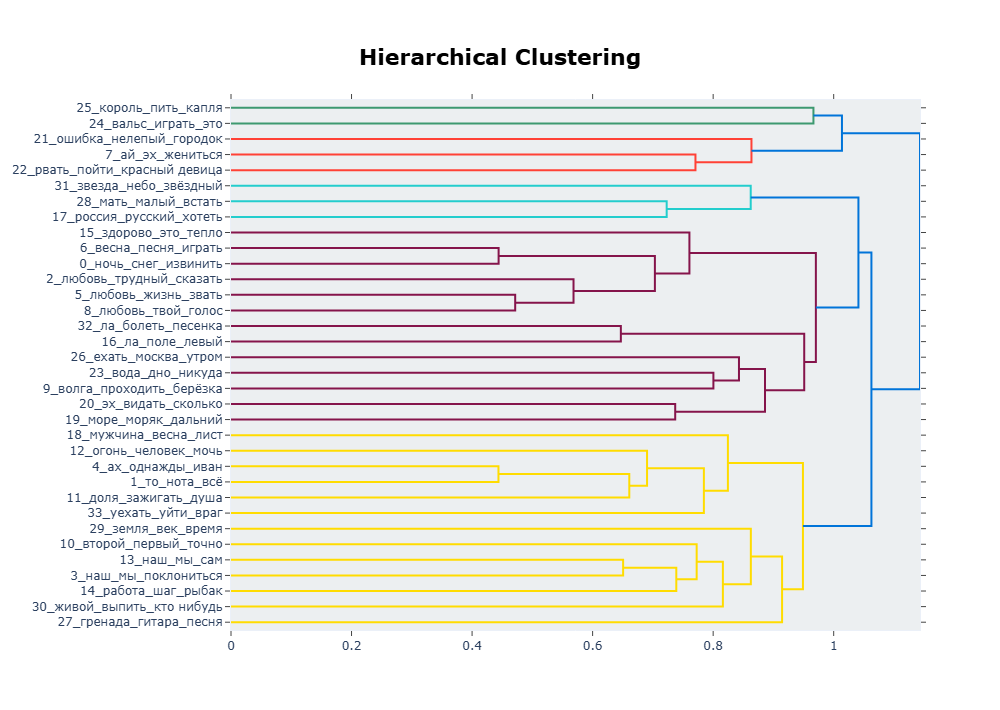

In [ ]:
bertopic_model.visualize_heatmap()

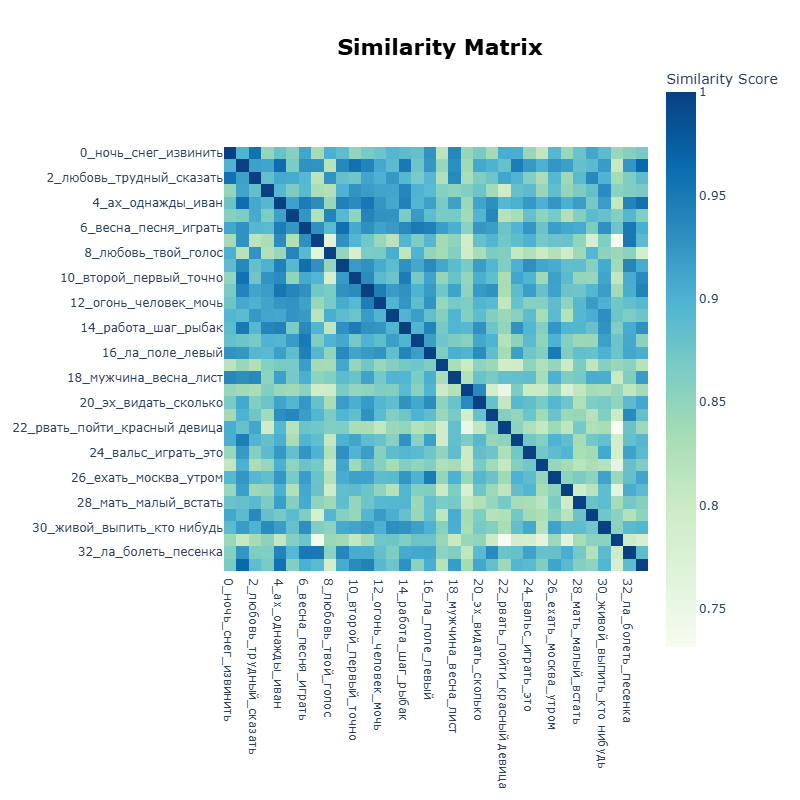

Исходя из тематического моделирования и визуализации полученных результатов можно сделать вывод о том, какие темы выделяются: тема войны (кластер 3), тема жизни, мира (кластер 5), тема радости (кластер 6) и тема сложности отношений (кластер 2)

Сравним темы, определенные BERTopic с разметкой датасета по темам

In [22]:
tags = " ".join(df["Tag"])
tags_preprocessed = re.sub(r"[^а-яА-ЯёЁ\s]", "", tags).lower()
tags_final = set(tags_preprocessed.split())
tags_final

{'вера',
 'война',
 'герои',
 'город',
 'грусть',
 'детство',
 'дом',
 'другое',
 'дружба',
 'жизнь',
 'космос',
 'любовь',
 'люди',
 'мама',
 'мать',
 'надежда',
 'одиночество',
 'память',
 'победа',
 'подвиг',
 'природа',
 'путешествие',
 'радость',
 'разлука',
 'революция',
 'религия',
 'родина',
 'родины',
 'свобода',
 'сказка',
 'смерть',
 'спорт',
 'судьба',
 'творчество',
 'труд'}

К кластеру 3 (война) подходят тэги "война", "герои", "победа", "подвиг", "смерть"; к кластеру 5, жизнь и мир тэги "жизнь", "свобода"; к кластеру 6, тема радости, тэги "радость", "свобода"; к кластеру 2 о сложности отношений подходят тэги "любовь", "одиночество", "разлука".

Вывод: тематическое моделирование с помощью модели BERTopic помогло выделить кластеры, на основании которых можно классифицировать песни из корпуса советской песни. Данные кластеры совпали с целевой разметкой и покрыли большинство тэгов корпуса